# Pro задание

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).


In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианта моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Акции лукойл/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Акции лукойл/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]
data = pd.concat([data16_17,data18_19]) # Объединяем
data = data.reset_index(drop = True) #Обнуляем индексы
data #Выводим таблицу

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231
...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523
481868,5183.5,5183.5,5183.5,5183.5,5090
481869,5183.5,5183.5,5183.5,5183.5,230
481870,5183.5,5183.5,5183.5,5183.5,5


In [ ]:
col = data.columns #Получаем названия столбцов
print(col) #Выводим

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [ ]:
#Задаем циклы для столбцов таким образом, чтобы происходил перебор всех возможных пар:
#Проходим по индексам массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 
#получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д
for i in range(col.shape[0]):                                                   #Для всех пар
  for j in range(i + 1 , col.shape[0]):                                         #Считаем
    data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]]                   #Разности
    data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]])  #Модули разностей
    data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]]                   #Произведения

#Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' считаем:
for i in col:
  data['Обратный ' + i] = 1 / (data[i] + 1e-3) #обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
  data['Производная от ' + i] = np.nan #Создаем пустой столбец 
  data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True) #При помощи срезов считаем первые производные .reset_index(drop=True) нужен для корректных подсчетов
  data['Вторая производная от ' + i] = np.nan #Создаем пустой столбец 
  data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True) #При помощи срезов считаем вторые производные 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
data #Смотрим, что получилось

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,OPEN*MIN,OPEN-CLOSE,|OPEN-CLOSE|,OPEN*CLOSE,OPEN-VOLUME,|OPEN-VOLUME|,OPEN*VOLUME,MAX-MIN,|MAX-MIN|,MAX*MIN,MAX-CLOSE,|MAX-CLOSE|,MAX*CLOSE,MAX-VOLUME,|MAX-VOLUME|,MAX*VOLUME,MIN-CLOSE,|MIN-CLOSE|,MIN*CLOSE,MIN-VOLUME,|MIN-VOLUME|,MIN*VOLUME,CLOSE-VOLUME,|CLOSE-VOLUME|,CLOSE*VOLUME,Обратный OPEN,Производная от OPEN,Вторая производная от OPEN,Обратный MAX,Производная от MAX,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,5524850.00,1.0,1.0,5524850.00,-196.0,196.0,5987997.0,5.8,5.8,5536130.00,5.8,5.8,5536130.00,-191.2,191.2,6000222.6,0.0,0.0,5522500.00,-197.0,197.0,5985450.0,-197.0,197.0,5985450.0,0.000425,NaN,NaN,0.000424,NaN,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,5529315.00,-2.8,2.8,5542726.53,2157.9,2157.9,458815.5,5.7,5.7,5535895.00,0.0,0.0,5549322.49,2160.7,2160.7,459361.5,-5.7,5.7,5535895.00,2155.0,2155.0,458250.0,2160.7,2160.7,459361.5,0.000425,1.9,NaN,0.000425,-0.1,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,5538957.84,1.5,1.5,5545317.96,2098.6,2098.6,605389.2,4.6,4.6,5539898.40,1.9,1.9,5546259.60,2099.0,2099.0,605492.0,-2.7,2.7,5535430.74,2094.4,2094.4,604309.8,2097.1,2097.1,605003.7,0.000425,2.7,0.8,0.000424,0.3,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,5535900.40,0.8,0.8,5541786.65,1591.5,1591.5,1796483.5,3.8,3.8,5537076.00,1.3,1.3,5542963.50,1592.0,1592.0,1796865.0,-2.5,2.5,5534019.44,1588.2,1588.2,1793965.6,1590.7,1590.7,1795873.1,0.000425,-1.1,-3.8,0.000425,-1.0,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,5537079.61,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,0.8,0.8,5538962.09,0.3,0.3,5540139.04,2122.9,2122.9,543750.9,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,2122.6,2122.6,543681.6,0.000425,-1.4,-0.3,0.000425,-1.1,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,-26339.5,26339.5,163399470.5,0.000193,13.5,13.5,0.000193,11.5,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,93.5,93.5,26384015.0,0.0,0.0,26868672.25,0.0,0.0,26868672.25,93.5,93.5,26384015.0,0.0,0.0,26868672.25,93.5,93.5,26384015.0,93.5,93.5,26384015.0,0.000193,0.0,-13.5,0.000193,0.0,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,0.0,0.0,26868672.25,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,4953.5,4953.5,1192205.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,5178.5,5178.5,25917.5,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [ ]:
data = np.array(data.iloc[2:]) #Берем все столбцы с первых двух
data = np.array(data) #Переводим в numpy
columnsamount = data.shape[1] #При помощи этой переменной будем использовать одну и ту же архитектуру под разные матрицы

**Функция загрузки данных**

In [ ]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т. к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
xTrain[0]

array([7.95549374e-02, 7.82709985e-02, 7.87523084e-02, 7.91423298e-02,
       5.98183431e-05, 9.97260274e-01, 2.73972603e-03, 4.30300821e-02,
       2.47058824e-02, 2.47058824e-02, 4.32954053e-02, 6.48793566e-01,
       1.25523013e-02, 4.30775888e-02, 9.99094556e-01, 4.89042680e-04,
       2.76290371e-05, 2.70588235e-02, 2.70588235e-02, 4.28884957e-02,
       1.85365854e-02, 1.85365854e-02, 4.30582515e-02, 9.99094649e-01,
       4.89135893e-04, 2.76337287e-05, 9.77593361e-01, 2.24066390e-02,
       4.31147298e-02, 9.99093579e-01, 4.88063942e-04, 2.75797749e-05,
       9.99094207e-01, 4.88693131e-04, 2.76114434e-05, 7.97515918e-01,
       4.70294785e-01, 5.06467662e-01, 8.00801025e-01, 4.13608247e-01,
       5.50337838e-01, 7.99284485e-01, 4.90387374e-01, 3.41990521e-01,
       7.98420931e-01, 4.60678643e-01, 4.63214286e-01, 3.89080269e-06,
       4.99379452e-01, 6.73841210e-01])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 50) (20, 1)


## Визуализация результатов

In [ ]:
# Функция рассчитывает результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходный масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка, с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции двух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисует корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для расчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график корреляций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Полносвязная сеть

Epoch 1/20
22579/22579 [==============================] - 94s 4ms/step - loss: 0.0061 - val_loss: 0.0110
Epoch 2/20
22579/22579 [==============================] - 93s 4ms/step - loss: 6.0378e-04 - val_loss: 7.1288e-04
Epoch 3/20
22579/22579 [==============================] - 95s 4ms/step - loss: 3.3218e-04 - val_loss: 5.1155e-04
Epoch 4/20
22579/22579 [==============================] - 93s 4ms/step - loss: 1.9470e-04 - val_loss: 0.0015
Epoch 5/20
22579/22579 [==============================] - 93s 4ms/step - loss: 1.2335e-04 - val_loss: 6.7443e-06
Epoch 6/20
22579/22579 [==============================] - 94s 4ms/step - loss: 1.1764e-04 - val_loss: 1.9738e-05
Epoch 7/20
22579/22579 [==============================] - 94s 4ms/step - loss: 9.2912e-05 - val_loss: 1.4233e-05
Epoch 8/20
22579/22579 [==============================] - 93s 4ms/step - loss: 1.3769e-04 - val_loss: 6.1034e-06
Epoch 9/20
22579/22579 [==============================] - 93s 4ms/step - loss: 9.4871e-05 - val_loss: 4.9698

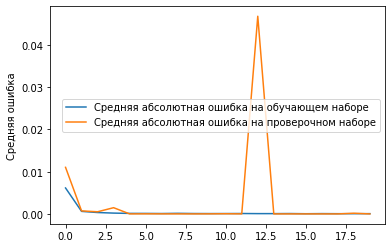

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,columnsamount), activation="linear" )) 
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

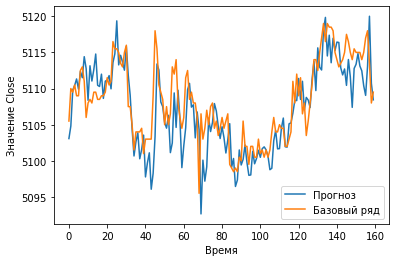

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


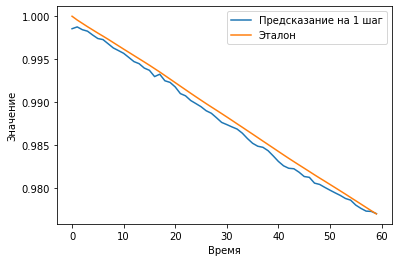

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

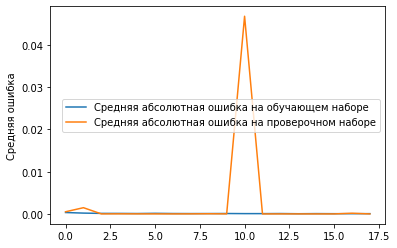

In [ ]:
#Выводим графики
plt.plot(history.history['loss'][2:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][2:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Одномерная свёртка

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen, columnsamount), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 251s 11ms/step - loss: 0.1982 - val_loss: 8.3754e-04
Epoch 2/20
22579/22579 [==============================] - 251s 11ms/step - loss: 0.0059 - val_loss: 6.2002e-05
Epoch 3/20
22579/22579 [==============================] - 249s 11ms/step - loss: 7.1113e-04 - val_loss: 3.0314e-04
Epoch 4/20
22579/22579 [==============================] - 275s 12ms/step - loss: 2.2739e-04 - val_loss: 1.8838e-05
Epoch 5/20
22579/22579 [==============================] - 268s 12ms/step - loss: 6.6862e-05 - val_loss: 1.2387e-05
Epoch 6/20
22579/22579 [==============================] - 257s 11ms/step - loss: 7.2650e-05 - val_loss: 2.0364e-05
Epoch 7/20
22579/22579 [==============================] - 281s 12ms/step - loss: 4.7977e-05 - val_loss: 7.8071e-05
Epoch 8/20
22579/22579 [==============================] - 271s 12ms/step - loss: 3.3944e-05 - val_loss: 0.0015
Epoch 9/20
22579

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

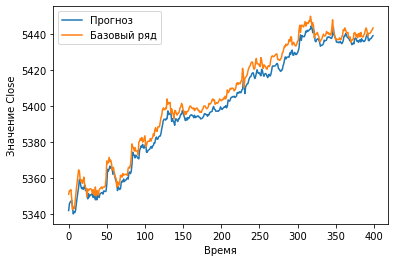

In [ ]:
#Отображаем графики
showPredict(10000, 400, 0, predVal, yValUnscaled)

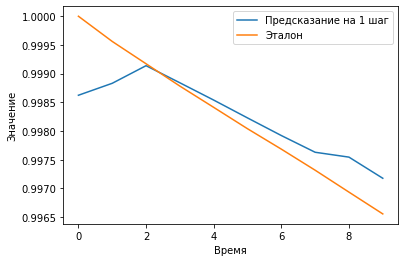

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Увеличенный "просмотр сети в прошлое" без наращивания данных

In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Акции лукойл/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Акции лукойл/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]
data = pd.concat([data16_17,data18_19]) # Объединяем
data = data.reset_index(drop = True) #Обнуляем индесы
data #Выводим таблицу

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231
...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523
481868,5183.5,5183.5,5183.5,5183.5,5090
481869,5183.5,5183.5,5183.5,5183.5,230
481870,5183.5,5183.5,5183.5,5183.5,5


In [ ]:
data = np.array(data) #Переводим в numpy
columnsamount = data.shape[1] #При помощи этой переменной будем использовать одну и ту же архитетуру под разные матрицы

In [ ]:
#Собственная функция для формирования обучающей и тестовой выборки для временных рядов 
#numofpoints - число точек, выбираемых с определенным шагом
#stepamongpoints - шаг, с которым выбираются точки 
#continuouslinelen - длина выборки, выбираемая "как есть"
#stride - шаг, с которым предсказываем

def ourTimeseriesGenerator(xTrain, yTrain, numofpoints = 100, stepamongpoints = 10, continuouslinelen = 100, stride = 1):
  x, y, = [], [] #Создаем списки для x и для y

  index = 0 #Начальный индекс задаем равный нулю 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints
  periodlinelen = stepamongpoints * (numofpoints - 1) + 1 

  #считаем длину вектора, который мы захватим при раскусывании на numofpoints точек с шагом stepamongpoints и на участок с непрерывной линией
  line = periodlinelen + continuouslinelen

  while index + line + stride < xTrain.shape[0]: # Определеям, позволяет ли длина выборки раскусить данные 

    endperiodline = index + periodlinelen #Вычисляем индекс, где закончится раскусывание с шагом
    periodline = xTrain[index:endperiodline:stepamongpoints] #Раскусываем с шагом
    continuousline = xTrain[endperiodline: endperiodline + continuouslinelen] #Берем непрерывную линию

    x.append(np.concatenate([periodline, continuousline])) #Объединяем две линии и добавляем в x
    y.append(yTrain[endperiodline + continuouslinelen - 1 + stride]) #Элемент, следующий после выборки x через шаг stride отправляем в y
    index += 1 #Увеличиваем индекс на 1

  x = np.array(x) #Преобразуем в numpy
  y = np.array(y) #Преобразуем в numpy
  
  return x, y #Возвращаем x и y

In [ ]:
##Формируем параметры загрузки данных

valLen = 30000                  #Используем 30.000 записей для проверки
numofpoints = 100
stepamongpoints = 10
continuouslinelen = 100

trainLen = data.shape[0] - valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen + stepamongpoints * (numofpoints - 1) + 2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т. к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen + stepamongpoints * (numofpoints - 1) + 2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

xTrainFinal, yTrainFinal = ourTimeseriesGenerator(xTrain, yTrain)
xTestFinal, yTestFinal = ourTimeseriesGenerator(xTest, yTest)

In [ ]:
print(xTrainFinal.shape)
print(yTrainFinal.shape)
print(xTestFinal.shape)
print(yTestFinal.shape)

(450780, 200, 5)
(450780, 1)
(27916, 200, 5)
(27916, 1)


Epoch 1/20
14087/14087 [==============================] - 45s 3ms/step - loss: 1.0058e-04 - val_loss: 1.4000e-04
Epoch 2/20
14087/14087 [==============================] - 52s 4ms/step - loss: 2.9657e-05 - val_loss: 3.0544e-06
Epoch 3/20
14087/14087 [==============================] - 65s 5ms/step - loss: 1.2526e-05 - val_loss: 2.1822e-06
Epoch 4/20
14087/14087 [==============================] - 58s 4ms/step - loss: 7.5860e-06 - val_loss: 1.8284e-06
Epoch 5/20
14087/14087 [==============================] - 56s 4ms/step - loss: 5.0419e-06 - val_loss: 5.2263e-06
Epoch 6/20
14087/14087 [==============================] - 49s 4ms/step - loss: 3.6366e-06 - val_loss: 1.1612e-06
Epoch 7/20
14087/14087 [==============================] - 55s 4ms/step - loss: 3.2477e-06 - val_loss: 1.6904e-05
Epoch 8/20
14087/14087 [==============================] - 53s 4ms/step - loss: 2.9309e-06 - val_loss: 6.4957e-06
Epoch 9/20
14087/14087 [==============================] - 50s 4ms/step - loss: 2.6105e-06 - val_

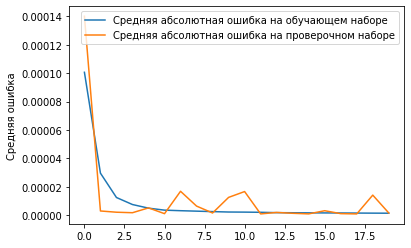

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (200, columnsamount), activation="linear" )) 
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit(xTrainFinal,
                     yTrainFinal, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = (xTestFinal, yTestFinal) 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

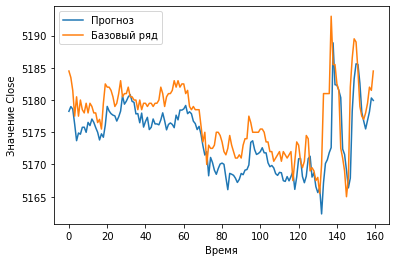

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xTestFinal, yTestFinal, yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


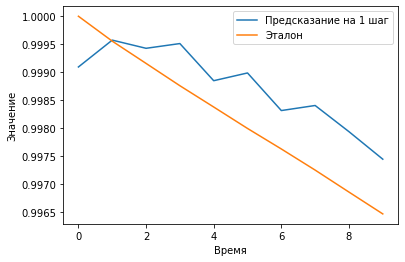

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)